# Prediction of thermodynamic properties based on functional groups

### Load Dataset

In [17]:
import pandas as pd
df = pd.read_csv("functional_group_counts_with_Thermodynamics.csv")  
print(df.shape) # Display the shape of the DataFrame
df.head()   # Display the first five rows of the DataFrame

(11001, 29)


,Molecule,=O,O,C,N,-O,=N,=N-O,-C(=O)H,-C#CH,...,-cPropyl,-tBu,-C(=O)OMe,-C(=O)O,-NC(=O)CH3,U0,U,H,G,Cv
0,O=C1C=CON=N1,21.0,2.0,3,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-375.430225,-375.421157,-375.420213,-375.469933,24.943
1,O=C1C=NOC=N1,21.0,2.0,3,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-375.359188,-375.354066,-375.353122,-375.388412,17.987
2,O=C1C=NON=C1,12.0,2.0,3,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-375.307060,-375.301908,-375.300964,-375.336105,18.514
3,O=C1C=NON=N1,21.0,2.0,2,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-391.337881,-391.332272,-391.331328,-391.367925,19.012
4,O=C1N=CON=N1,20.0,2.0,2,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-391.518453,-391.509552,-391.508608,-391.558096,23.419


##### Remove Unwanted Features

In [18]:
df = df.drop(columns=['Molecule','Cv']) # Drop unwanted features
df.shape

(11001, 27)

##### Set Features and Targets

In [19]:
target_cols = ['U0','U','H','G']

feature_cols = df.drop(columns=target_cols).columns         # Includes number of functional groups & atoms
X = df[feature_cols]
y = df[target_cols]     
X.shape

(11001, 23)

##### Detect Feature with Less Correlation to Targets and Remove Them

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculate correlation between features and targets
feature_target_corr = pd.DataFrame()

# For each target, get absolute correlation with all features
for target in target_cols:
    # Calculate correlation between each feature and this target
    feature_target_corr[target] = X.corrwith(df[target]).abs()

# Get the maximum correlation across all targets for each feature
max_corr = feature_target_corr.max(axis=1)

# Set correlation threshold
threshold = 0.01

# Select features with correlation above threshold
selected_features = max_corr[max_corr > threshold].index.tolist()
print(f"Original feature count: {len(feature_cols)}")
print(f"Features with correlation > {threshold}: {len(selected_features)}")

# Plot feature correlations sorted
plt.figure(figsize=(10, 6))
max_corr.sort_values(ascending=False).plot(kind='bar')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.title(f'Maximum Absolute Correlation with Target Variables')
plt.xlabel('Features')
plt.ylabel('Maximum Correlation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Update X with selected features only
X_filtered = X[selected_features]
print(f"X shape after feature selection: {X_filtered.shape}")
X = X_filtered          # Update X to only include selected features


##### Split Dataset into Train and Test

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)


##### Model Evaluation: Cross-Validation and Test Performance

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define models (SVR removed)
models = {
    'Ridge': Ridge(),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1)
}

# Evaluate models
for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="neg_mean_squared_error")
    cv_rmse = np.sqrt(-cv_scores).mean()
    print(f"{name} - CV RMSE: {cv_rmse:.3f}")

    # Fit and test performance
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    print(f"{name} - Test RMSE: {test_rmse:.3f}, R²: {test_r2:.3f}")

Ridge - CV RMSE: 1.168
Ridge - Test RMSE: 1.170, R²: 0.998
Random Forest - CV RMSE: 1.706
Random Forest - Test RMSE: 1.235, R²: 0.998


##### Hyperparameter Tuning for Ridge Regression using GridCV

In [22]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Ridge
ridge_param_grid = {
    "alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg"]
}

# Perform GridSearchCV
ridge_grid_search = GridSearchCV(
    Ridge(random_state=42),
    param_grid=ridge_param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

# Fit the model and display the best parameters
ridge_grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", ridge_grid_search.best_params_)

# Fit the best model on the entire training set
ridge_best_model = ridge_grid_search.best_estimator_
ridge_best_model.fit(X_train_scaled, y_train)

# Predict on the test set
ridge_y_pred = ridge_best_model.predict(X_test_scaled)

# Evaluate the model
ridge_test_rmse = np.sqrt(mean_squared_error(y_test, ridge_y_pred))
ridge_test_r2 = r2_score(y_test, ridge_y_pred)
print(f"Best Ridge - Test RMSE: {ridge_test_rmse:.3f}, R²: {ridge_test_r2:.3f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'alpha': 0.001, 'solver': 'sparse_cg'}
Best Ridge - Test RMSE: 1.147, R²: 0.999


##### Visualization: Plotting Residual Plots and Learning Curve

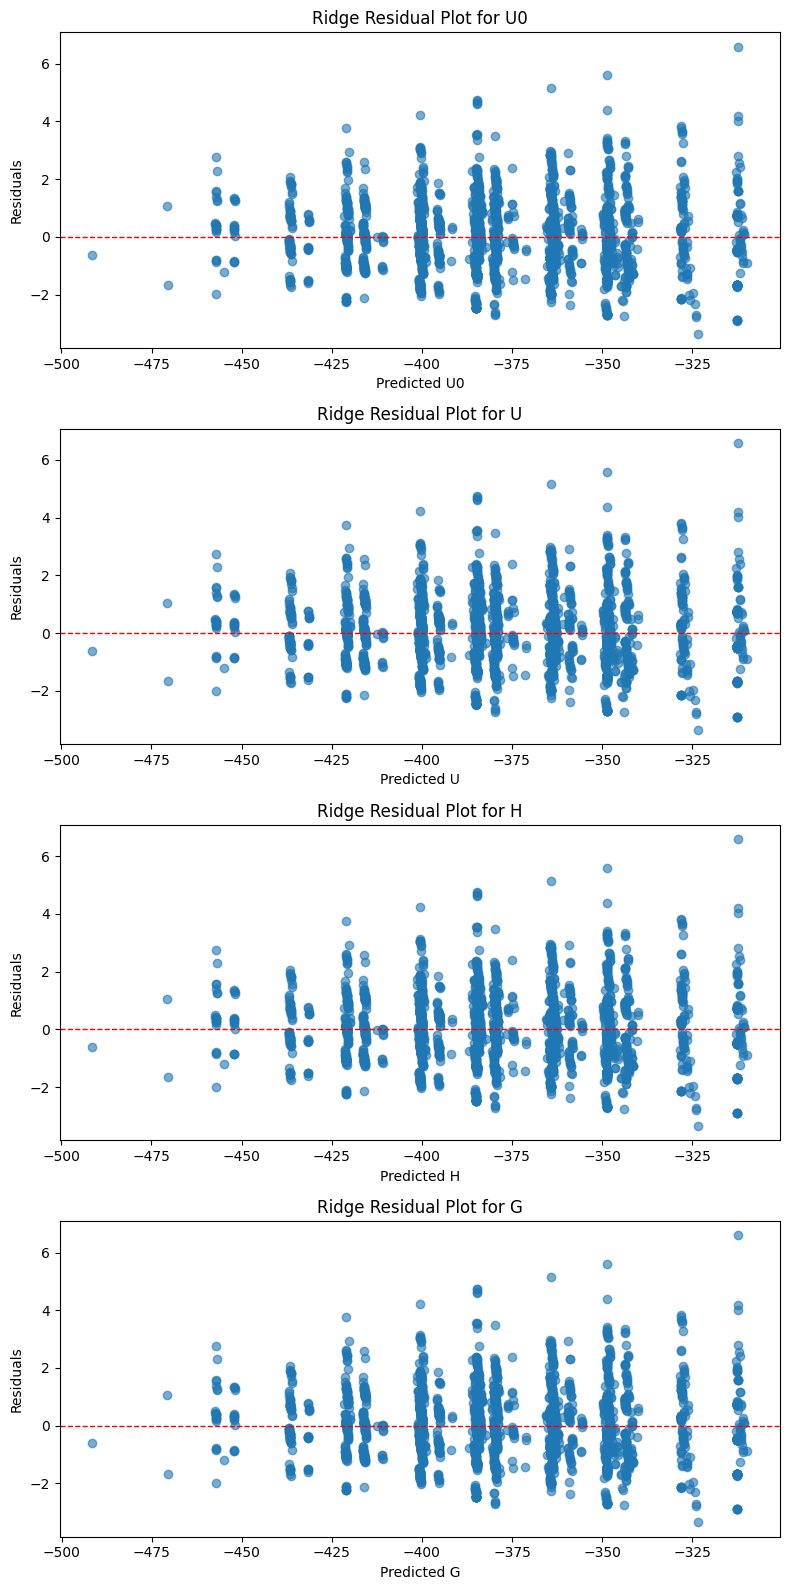

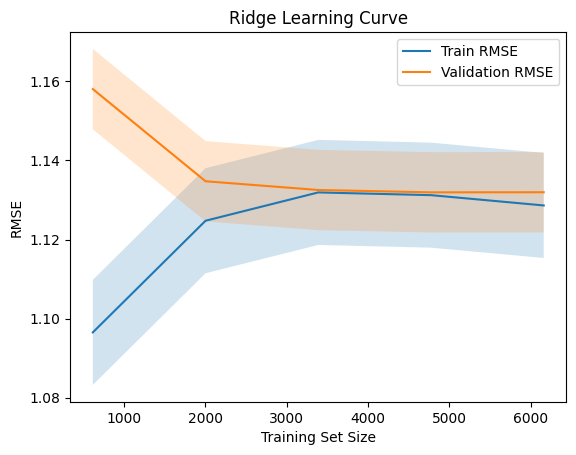

In [23]:
from sklearn.model_selection import learning_curve

# Residual plots for each target using Ridge model
import matplotlib.pyplot as plt

n_targets = len(target_cols)
fig, axes = plt.subplots(n_targets, 1, figsize=(8, 4 * n_targets))

for i, target in enumerate(target_cols):
    ax = axes[i] if n_targets > 1 else axes
    residuals = y_test[target] - ridge_y_pred[:, i]
    ax.scatter(ridge_y_pred[:, i], residuals, alpha=0.6)
    ax.axhline(0, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel(f"Predicted {target}")
    ax.set_ylabel("Residuals")
    ax.set_title(f"Ridge Residual Plot for {target}")

plt.tight_layout()
plt.show()

# Learning curve for Ridge model

# Generate learning curves and calculate RMSE
train_sizes, train_scores, val_scores = learning_curve(
    ridge_best_model, X_train_scaled, y_train, cv=5, scoring="neg_mean_squared_error", n_jobs=-1
)
train_rmse = np.sqrt(-train_scores).mean(axis=1)
val_rmse = np.sqrt(-val_scores).mean(axis=1)

# Plot learning curves
plt.plot(train_sizes, train_rmse, label="Train RMSE")
plt.plot(train_sizes, val_rmse, label="Validation RMSE")
plt.fill_between(train_sizes, train_rmse - train_rmse.std(), train_rmse + train_rmse.std(), alpha=0.2)
plt.fill_between(train_sizes, val_rmse - val_rmse.std(), val_rmse + val_rmse.std(), alpha=0.2)
plt.title("Ridge Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend()
plt.show()